<a href="https://colab.research.google.com/github/reflectormensah/Financial-Engineering-Data-Science/blob/main/ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install nelson_siegel_svensson
! pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import statsmodels.api as sm
import pandas_datareader as pdr
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

# Step 0 Define some useful variables
start_date = "2019-10-01"
end_date = "2019-11-30"

# Step 1 Source ISFD.L (FTSE ETF) and IGLN.L (Gold ETF) price data & join them together
data_etf = yf.download("ISFD.L IGLN.L", start=start_date, end=end_date).reset_index()
data_etf["Date"] = [ ele.date() for ele in data_etf["Date"] ]
data_etf = data_etf.set_index("Date")
data_etf = data_etf[["Date", "Adj Close"]]
data_etf.columns = [ x.replace(".L","") for x in data_etf.columns.get_level_values(1) ]
data_etf = data_etf.reset_index()

data_ir = pdr.DataReader(['DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS30'], 'fred', start_date, end_date).fillna(method='ffill').reset_index().rename(columns={"DATE": "Date"})
data_ir["Date"] = [ ele.date() for ele in data_ir["Date"] ]
data_ir = data_ir.rename(columns={'DGS2':"2Y", 'DGS3':"3Y", 'DGS5':"5Y", 'DGS7':"7Y", 'DGS10':"10Y", 'DGS30':"30Y"})

assert len(data_etf["Date"])==len(data_ir["Date"])

data_full = data_etf.merge(data_ir, left_on="Date", right_on="Date", how="outer")

# Step 2 Compute ETF daily returns
data_full["ISFD_R"] = data_full["ISFD"]/data_full["ISFD"].shift(1)-1
data_full["IGLN_R"] = data_full["IGLN"]/data_full["IGLN"].shift(1)-1
data_full["Month"] = [ x.strftime("%b") for x in data_full["Date"] ]

data_full_avg = data_full.groupby("Month").agg(["mean", "std"])

# Step 3 Compute monthly mean and std dev for ETF and benchmarks
data_full["ISFD_R"] = data_full["ISFD"]/data_full["ISFD"].shift(1)-1
data_full["IGLN_R"] = data_full["IGLN"]/data_full["IGLN"].shift(1)-1
data_full["Month"] = [ x.strftime("%b") for x in data_full["Date"] ]

data_full_avg = data_full.groupby("Month").agg(["mean", "std"])


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[*********************100%***********************]  2 of 2 completed


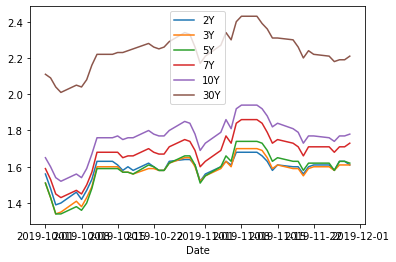

In [ ]:
# Step 4 Perform some graphing as required
data_full.set_index("Date")[["2Y", "3Y", "5Y", "7Y", "10Y", "30Y"]].plot()

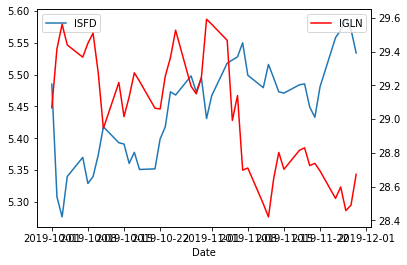

In [ ]:
# Step 4 Perform some graphing as required
ax = data_full.plot('Date','ISFD')
ax1 = ax.twinx()
data_full.plot('Date','IGLN',ax=ax1, color='r')

In [ ]:
# Step 5 Write down the Nelson SIegel Equation

### Nelson Siegel Equation

\begin{equation*}
f(m) = \beta_{0} + \beta_{1} e^\frac{-m}{\tau} + \frac{-m}{t} \beta_{2} e^\frac{-m}{\tau}
\end{equation*}

In [ ]:
# Step 5 FItting the Nelson Siegel yield curve for Oct and Nov

for idx, row in data_full.iterrows():
    t = np.array([ 2.0, 3.0, 5.0, 7.0, 10.0, 30.0 ])
    y = np.array([ row["2Y"], row["3Y"], row["5Y"], row["7Y"], row["10Y"], row["30Y"] ])
    curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
    assert status.success
    data_full.at[idx,"NS_beta0"] = curve.beta0
    data_full.at[idx,"NS_beta1"] = curve.beta1
    data_full.at[idx,"NS_beta2"] = curve.beta2
    data_full.at[idx,"NS_tau"] = curve.tau

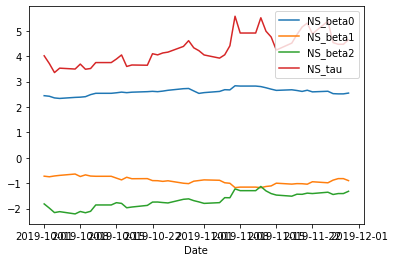

In [ ]:
data_full.set_index("Date")[["NS_beta0", "NS_beta1", "NS_beta2", "NS_tau"]].plot()

#### Step 5.4 What are the significant changes?
From the plot of the different beta and tau parameters, we can see that beta2 and tau are the 2 parameters which increase materially over the Oct-Nov period in reaction to the Fed Reserve's interest rate decisions.
The impact of the Fed decision on interest rates resulted in a steepening in the yield curve where the long term interest rates increased by a larger amount than short term interest rates.
The different Nelson Siegel parameters changed in line with the yield curve steepening, whereby an increase in beta2 and tau will lead to a diminishing value of the third term in the Nelson Siegel equation, which manifests itself in terms of an increased steepness of the calculated function value f(m)

In [ ]:
# Step 6 ARMA Modeling Pricing for Oct and Nov for Gold ETF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Filtering the DataFrame for Oct and Nov months separately
data_full_oct = data_full[data_full["Month"]=="Oct"]
data_full_nov = data_full[data_full["Month"]=="Nov"]

MODEL 1 FOR GOLD IN OCTOBER, ARMA(1,1)

In [ ]:
oct_gold_model = ARIMA( data_full_oct['IGLN'], order=(1,0,1)).fit()
oct_gold_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   IGLN   No. Observations:                   23
Model:                     ARMA(1, 1)   Log Likelihood                   9.066
Method:                       css-mle   S.D. of innovations              0.162
Date:                Tue, 11 Jan 2022   AIC                            -10.132
Time:                        05:37:24   BIC                             -5.590
Sample:                             0   HQIC                            -8.990
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.2788      0.054    539.156      0.000      29.172      29.385
ar.L1.IGLN     0.1477      0.354      0.418      0.681      -0.545       0.841
ma.L1.IGLN     0.3960      0.297      1.333      0.197      -0.186       0.978
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.7706           +0.0000j            6.7706            0.0000
MA.1           -2.5254           +0.0000j            2.5254            0.5000
-----------------------------------------------------------------------------
"""

MODEL 1 FOR GOLD IN NOVEMBER, ARMA(1,1)

In [ ]:
nov_gold_model = ARIMA(data_full_nov['IGLN'], order=(1,0,1)).fit()
nov_gold_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   IGLN   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                   5.220
Method:                       css-mle   S.D. of innovations              0.182
Date:                Tue, 11 Jan 2022   AIC                             -2.440
Time:                        05:37:35   BIC                              1.739
Sample:                             0   HQIC                            -1.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9136      0.268    107.774      0.000      28.388      29.439
ar.L1.IGLN     0.8848      0.127      6.979      0.000       0.636       1.133
ma.L1.IGLN    -0.0477      0.199     -0.239      0.814      -0.438       0.343
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1303           +0.0000j            1.1303            0.0000
MA.1           20.9730           +0.0000j           20.9730            0.0000
-----------------------------------------------------------------------------
"""

In Gold Prices, constant coefficient got decreased by approximately 36 points. Autoregression regression coefficient increased by approximately 73 points and moving average decreased by approximately 44 points. This shows that autogressive parameter is more stronger in November, signifying stronger relation to previous period. The moving average parameter is weak as it reduced in november in relation to previous period. This signifies a weak relationship in relation to prediction period

MODEL 1 FOR EQUITY IN OCTOBER, ARMA(1,1)

In [ ]:
oct_equity_model = ARIMA(data_full_oct['ISFD'], order=(1,0,1)).fit()
oct_equity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ISFD   No. Observations:                   23
Model:                     ARMA(1, 1)   Log Likelihood                  38.366
Method:                       css-mle   S.D. of innovations              0.045
Date:                Tue, 11 Jan 2022   AIC                            -68.732
Time:                        05:37:43   BIC                            -64.190
Sample:                             0   HQIC                           -67.590
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4044      0.025    215.549      0.000       5.355       5.454
ar.L1.ISFD     0.5163      0.237      2.180      0.041       0.052       0.981
ma.L1.ISFD     0.3437      0.252      1.364      0.188      -0.150       0.838
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9367           +0.0000j            1.9367            0.0000
MA.1           -2.9093           +0.0000j            2.9093            0.5000
-----------------------------------------------------------------------------
"""

MODEL 1 FOR EQUITY IN NOVEMBER, ARMA(1,1)

In [ ]:
nov_equity_model = ARIMA(data_full_nov['ISFD'], order=(1,0,1)).fit()
nov_equity_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ISFD   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  47.502
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 11 Jan 2022   AIC                            -87.004
Time:                        05:37:57   BIC                            -82.826
Sample:                             0   HQIC                           -86.097
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5068      0.016    352.671      0.000       5.476       5.537
ar.L1.ISFD     0.3897      0.205      1.897      0.074      -0.013       0.792
ma.L1.ISFD     1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5662           +0.0000j            2.5662            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

In Equity Prices, constant coefficient got increased by approximately 10 points. Autoregression regression coefficient decreased by approximately 13 points and moving average increased by approximately 66 points. This shows that autogressive parameter is more weak in November, signifying weaker relation to previous period. The moving average parameter was stronger in november in relation to previous period. This signifies a strong relationship in relation to prediction period

MODELLING VOLATILITY

Gold Analysis

In [ ]:
print('<<<<<<<<<<<<<<<<<<<<<<<GOLD>>>>>>>>>>>>>>>>>>')
print('October daily high minus low:',data_full_oct['IGLN'].max()-data_full_oct['IGLN'].min())

print('Novermber daily high minus low:', data_full_nov['IGLN'].max()-data_full_nov['IGLN'].min())

print('\nAverage & Std Dev of Gold in October & November:=')
print(data_full_avg["IGLN"])

<<<<<<<<<<<<<<<<<<<<<<<GOLD>>>>>>>>>>>>>>>>>>
October daily high minus low: 0.6475009918212891
Novermber daily high minus low: 1.1424999237060547

Average & Std Dev of Gold in October & November:=
            mean       std
Month                     
Nov    28.770714  0.301284
Oct    29.276413  0.185422


In [ ]:
# Garch(1,1) for Gold returns in October
# !pip install arch
from arch import arch_model

oct_gold_return_garch = arch_model(data_full_oct['IGLN_R'][1:],mean='Constant', vol= 'GARCH', p=1,q=1).fit()
oct_gold_return_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 989641.1596375244
Iteration:      2,   Func. Count:     17,   Neg. LLF: 16966652.289922733
Iteration:      3,   Func. Count:     24,   Neg. LLF: 47.28687860304075
Iteration:      4,   Func. Count:     31,   Neg. LLF: -79.22940976200154
Iteration:      5,   Func. Count:     37,   Neg. LLF: -79.241692561554
Iteration:      6,   Func. Count:     42,   Neg. LLF: -79.24281147552011
Iteration:      7,   Func. Count:     47,   Neg. LLF: -79.24260123356625
Iteration:      8,   Func. Count:     54,   Neg. LLF: -79.24248066478327
Iteration:      9,   Func. Count:     61,   Neg. LLF: 238738.0531768249
Iteration:     10,   Func. Count:     72,   Neg. LLF: -52.02550668794601
Iteration:     11,   Func. Count:     81,   Neg. LLF: -79.22947372644649
Optimization terminated successfully    (Exit mode 0)
            Current function value: -79.2430318949102
            Iterations: 12
            Function evaluations: 91
            Gradient evaluatio

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 IGLN_R   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                79.2430
Distribution:                  Normal   AIC:                          -150.486
Method:            Maximum Likelihood   BIC:                          -146.122
                                        No. Observations:                   22
Date:                Mon, Jan 10 2022   Df Residuals:                       21
Time:                        22:37:22   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.2077e-04  3.348e-03      0.245      0.806 [-5.740e-03,7.382e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.7241e-05  8.234e-10  2.094e+04      0.000 [1.724e-05,1.724e-05]
alpha[1]   5.1912e-05      3.565  1.456e-05      1.000     [ -6.987,  6.987]
beta[1]        0.5897      3.560      0.166      0.868     [ -6.388,  7.568]
============================================================================

Covariance estimator: robust
"""

In [ ]:
nov_gold_return_garch = arch_model(data_full_nov['IGLN_R'][1:],mean='Constant', vol= 'GARCH', p=1,q=1).fit()
nov_gold_return_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 161736774.19610873
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2861803.311616438
Iteration:      3,   Func. Count:     29,   Neg. LLF: 181771368648.84988
Iteration:      4,   Func. Count:     39,   Neg. LLF: 8404681750547.1455
Iteration:      5,   Func. Count:     50,   Neg. LLF: 180229424688.04547
Iteration:      6,   Func. Count:     60,   Neg. LLF: 8472002661358.783
Iteration:      7,   Func. Count:     70,   Neg. LLF: -73.77799990538662
Optimization terminated successfully    (Exit mode 0)
            Current function value: -73.77799999726832
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 IGLN_R   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                73.7780
Distribution:                  Normal   AIC:                          -139.556
Method:            Maximum Likelihood   BIC:                          -135.573
                                        No. Observations:                   20
Date:                Mon, Jan 10 2022   Df Residuals:                       19
Time:                        22:42:41   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.0103e-03  2.236e-07  -4518.399      0.000 [-1.011e-03,-1.010e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.9208e-06  8.186e-11  4.790e+04      0.000 [3.921e-06,3.921e-06]
alpha[1]       0.2000      0.556      0.360      0.719     [ -0.889,  1.289]
beta[1]        0.7000      0.309      2.265  2.351e-02   [9.428e-02,  1.306]
============================================================================

Covariance estimator: robust
"""

From the above, High minus Low increased significantly by approximately 49 points. This shows that the gold price in november outperferms the gold price in October. Also, the meean decreased by approximately 50 points. This shows that the performance of the gold price has a weakened relations to October performance. Also, the AIC and BIC coefficients increased from october to november.

Equity Analysis

In [ ]:
print('<<<<<<<<<<<<<<<<<<<<<<<EQUITY>>>>>>>>>>>>>>>>>>')
print('October daily high minus low:',data_full_oct['ISFD'].max()-data_full_oct['ISFD'].min())

print('Novermber daily high minus low:', data_full_nov['ISFD'].max()-data_full_nov['ISFD'].min())

print('\nAverage & Std Dev of Equity in October & November:=')
print(data_full_avg["ISFD"])

<<<<<<<<<<<<<<<<<<<<<<<EQUITY>>>>>>>>>>>>>>>>>>
October daily high minus low: 0.22149991989135742
Novermber daily high minus low: 0.15399980545043945

Average & Std Dev of Equity in October & November:=
           mean       std
Month                    
Nov    5.508190  0.042448
Oct    5.396544  0.062853


In [ ]:
# Garch(1,1) for Equity returns in October

oct_equity_return_garch = arch_model(data_full_oct['ISFD_R'][1:],mean='Constant', vol= 'GARCH', p=1,q=1).fit()
oct_equity_return_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16815694.753118694
Iteration:      2,   Func. Count:     17,   Neg. LLF: 506776488123.16943
Iteration:      3,   Func. Count:     26,   Neg. LLF: -73.25522230214722
Optimization terminated successfully    (Exit mode 0)
            Current function value: -73.25522239115618
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 ISFD_R   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                73.2552
Distribution:                  Normal   AIC:                          -138.510
Method:            Maximum Likelihood   BIC:                          -134.146
                                        No. Observations:                   22
Date:                Mon, Jan 10 2022   Df Residuals:                       21
Time:                        22:44:57   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.2615e-05  1.513e-03  5.461e-02      0.956 [-2.882e-03,3.047e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5981e-05  2.913e-06      8.919  4.685e-19 [2.027e-05,3.169e-05]
alpha[1]       0.2000      0.290      0.689      0.491     [ -0.369,  0.769]
beta[1]        0.5000      0.233      2.149  3.165e-02   [4.395e-02,  0.956]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# Garch(1,1) for Equity returns in November

nov_equity_return_garch = arch_model(data_full_nov['ISFD_R'][1:],mean='Constant', vol= 'GARCH', p=1,q=1).fit()
nov_equity_return_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4389514538793.4414
Iteration:      2,   Func. Count:     17,   Neg. LLF: -55.43667875888105
Iteration:      3,   Func. Count:     24,   Neg. LLF: -74.67475592596855
Iteration:      4,   Func. Count:     29,   Neg. LLF: -74.67503655864822
Iteration:      5,   Func. Count:     34,   Neg. LLF: -74.6753382692218
Iteration:      6,   Func. Count:     39,   Neg. LLF: -74.67537662969593
Iteration:      7,   Func. Count:     44,   Neg. LLF: -74.67569051864795
Iteration:      8,   Func. Count:     49,   Neg. LLF: -74.67980871431455
Iteration:      9,   Func. Count:     54,   Neg. LLF: -71.62478211458749
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2811.5325244045853
Iteration:     11,   Func. Count:     73,   Neg. LLF: -60.38101070897486
Iteration:     12,   Func. Count:     82,   Neg. LLF: -53.55131782912466
Iteration:     13,   Func. Count:     88,   Neg. LLF: -54.56995116572706
Iteration:     14,   Func. Count:     94,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 ISFD_R   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                74.7379
Distribution:                  Normal   AIC:                          -141.476
Method:            Maximum Likelihood   BIC:                          -137.493
                                        No. Observations:                   20
Date:                Mon, Jan 10 2022   Df Residuals:                       19
Time:                        22:45:56   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.5834e-04  1.224e-03      0.211      0.833 [-2.141e-03,2.658e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5096e-05  5.209e-07     48.180      0.000 [2.408e-05,2.612e-05]
alpha[1]       0.3072      2.500      0.123      0.902     [ -4.593,  5.208]
beta[1]    9.1130e-16      1.875  4.859e-16      1.000     [ -3.676,  3.676]
============================================================================

Covariance estimator: robust
"""

From the above, High minus Low decreased by approximately 7 points. This shows that the gold price in november did not perform well against the gold price in October. Also, the meean increased by approximately  points. This shows that the performance of the gold price has quite strong relations in relations to October performance. Also, the AIC and BIC are become more negative.

In [ ]:
# Correlation in October and November on Returns
oct_coefficient = np.corrcoef(data_full_oct['IGLN_R'][1:], data_full_oct['ISFD_R'][1:])
nov_coefficient = np.corrcoef(data_full_nov['IGLN_R'][1:], data_full_nov['ISFD_R'][1:])
print('The Correalation in October:=',oct_coefficient)
print('The Correlation in November:=',nov_coefficient)




The Correalation in October:= [[ 1.        -0.5906827]
 [-0.5906827  1.       ]]
The Correlation in November:= [[ 1.         -0.33818019]
 [-0.33818019  1.        ]]


1. From the October, the correlation coefficient is -0.59 signifying a moderate negative correlation. This means that, a returnof,(say USD 1 on Gold) prices increases, will result in decrease of return of $0.59 on equity prices.

2. From the November, the correlation coefficient is -0.34 signifying a moderate negative correlation. This means that, a return(of, say USD 1) on Gold prices increases, will result in decrease of return of $0.33 on equity prices.